In [1]:
from ADsurf._ADsurf import *

data_path = "./data/01_article/increase_layer/"

## 1. Model parameter

In [3]:
dc = 0.01
vmin = 2
vmax = 3.2
tmin = 1/10
tmax = 5
layering_method = "LN"
initialize_method = "Brocher"
layering_ratio = 1.2
depth_factor=  3.8
layer_number = 6
vp_vs_ratio = 2.45
rho = 2
multimodal = False
fundamental_range = []
model_parameter = model_param(
            dc=dc,
            vmin=vmin,
            vmax=vmax,
            tmin=tmin,
            tmax=tmax,
            layering_method=layering_method,
            initialize_method=initialize_method,
            layering_ratio=layering_ratio,
            depth_factor=depth_factor,
            layer_number=layer_number,
            vp_vs_ratio=vp_vs_ratio,
            rho=rho,
            multimodal=multimodal,
            fundamental_range = fundamental_range
            )

## 2. inversion parameter

In [10]:
inversion_method = "VsAndThick"
wave = "rayleigh"
algorithm = "dunkin"
itype = 0
mode = 0
compress = True
compress_method="exp"
normalized = True
lr = 0.005
damp_vertical = 0.002
damp_horizontal = 0
iteration = 1000
step_size = 200
gamma = 0.75
optimizer="Adam"

inversion_parameter = inv_param(
                inversion_method=inversion_method,
                wave=wave,
                algorithm=algorithm,
                mode=mode,
                compress=compress,
                compress_method=compress_method,
                normalized=normalized,
                lr=lr,
                damp_vertical=damp_vertical,
                damp_horizontal=damp_horizontal,
                iteration=iteration,
                step_size=step_size,
                gamma=gamma,
                optimizer=optimizer
)

## 3.Model parameterization and initializing

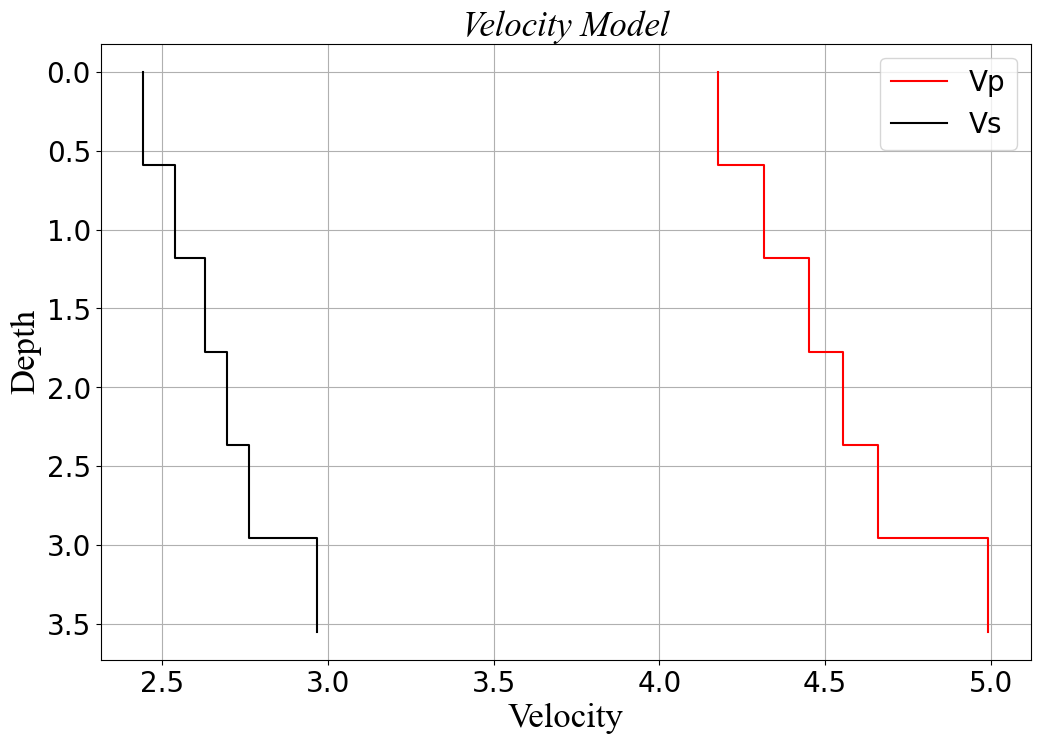

In [11]:
pvs_obs = np.loadtxt(os.path.join(data_path,"input/disper.txt"))
thick = [0.4,0.5,0.5,0.5,0.5,0.5]
initial_model = init_model(
                        model_param = model_parameter,
                        pvs_obs=pvs_obs,
                        thick=thick
                        )
plot_velModel(thick=initial_model.init_model["thick"],
            vp = initial_model.init_model["vp"],
            vs= initial_model.init_model["vs"],
            )

## 4. inversion

In [12]:
inversion_model = inversion(
                        model_param = model_parameter,
                        inv_param = inversion_parameter,
                        init_model=initial_model,
                        pvs_obs=pvs_obs,
                        vsrange_sign="mul",
                        vsrange=[0.1,2],
                        AK135_data=[],
                        device="cpu"
                        )

Iter:999,lr:0.005,DampV:0.002,loss sum:0.0005062: 100%|██████████| 1000/1000 [01:35<00:00, 10.52it/s]


## 5. plotting

In [13]:
if not os.path.exists(os.path.join(data_path,"output/figure")):
    os.makedirs(os.path.join(data_path,"output/figure"))
if not os.path.exists(os.path.join(data_path,"output/data")):
    os.mkdir(os.path.join(data_path,"output/data"))

### 5.1 misfit function

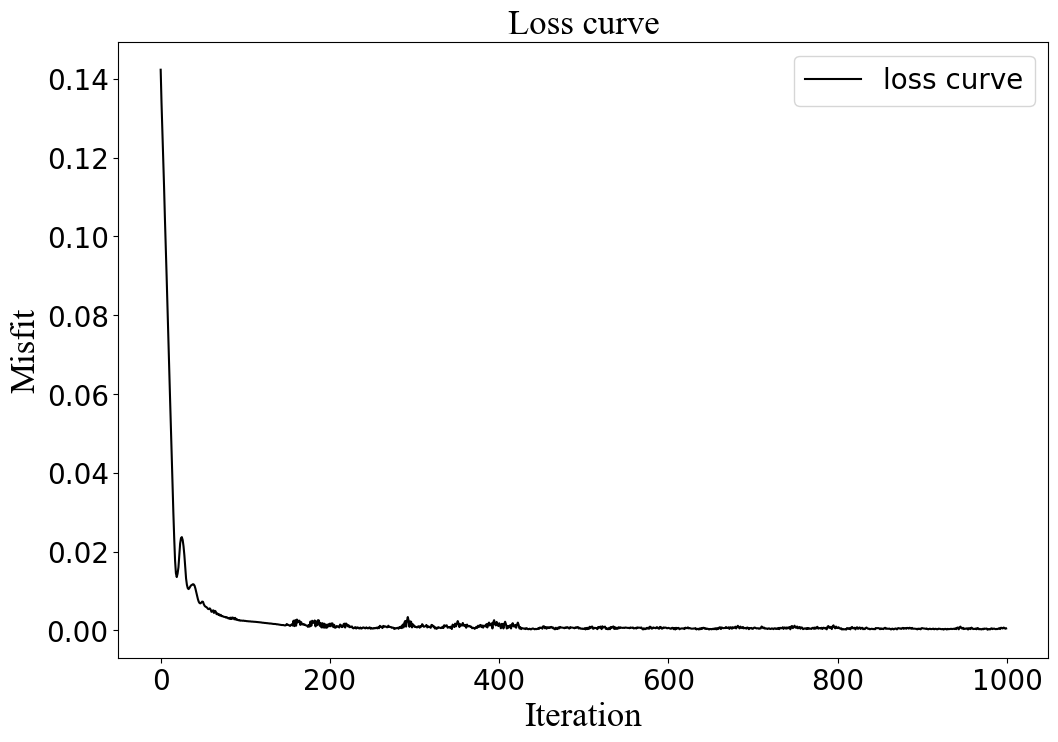

(977, 0.00018301696104735962)

In [14]:
plot_loss(inversion_model.inv_process["loss"],
          save_path=os.path.join(data_path,"output/figure/loss_curve.png")
          )
best_num = np.argmin(inversion_model.inv_process["loss"])
best_num,inversion_model.inv_process["loss"][best_num]

### 5.2 inversion result's comparation

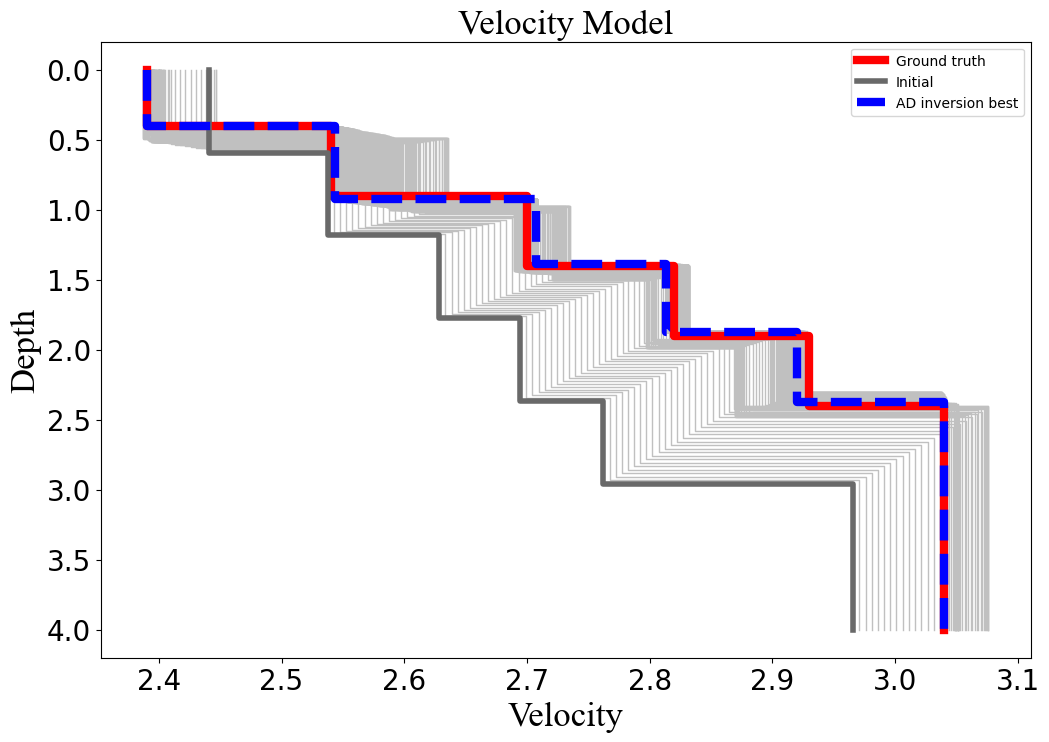

In [15]:
### inversion reuslt 
iter_vs = list2numpy(inversion_model.inv_process["iter_vs"])
vs_init = list2numpy(initial_model.init_model["vs"])
thick_init = list2numpy(initial_model.init_model["thick"])
if inversion_method == "VsAndThick":
    iter_thick = list2numpy(inversion_model.inv_process["iter_thick"])
else:
    iter_thick = np.ones_like(iter_vs)*thick_init
vs_matlab = []
thick_matlab = []
best_num = np.argmin(list2numpy(inversion_model.inv_process["loss"]))
thick_true = np.array([0.4,0.5,0.5,0.5,0.5,0.5])
vs_true = np.array([2.39,2.54,2.7,2.82,2.93,3.04])
plot_allModel(vs_inversion=iter_vs,thick_inversion=iter_thick,
            vs_true=vs_true,thick_true=thick_true,
            vs_init=vs_init,thick_init=thick_init,
            vs_matlab=vs_matlab,thick_matlab=thick_matlab,
            best_index=best_num,
            plot_all=True,
            save_path=os.path.join(data_path,"output/figure/Inversion_result.png"),
            largest_depth=4,
            )

### 5.3 inversion result's determinant image

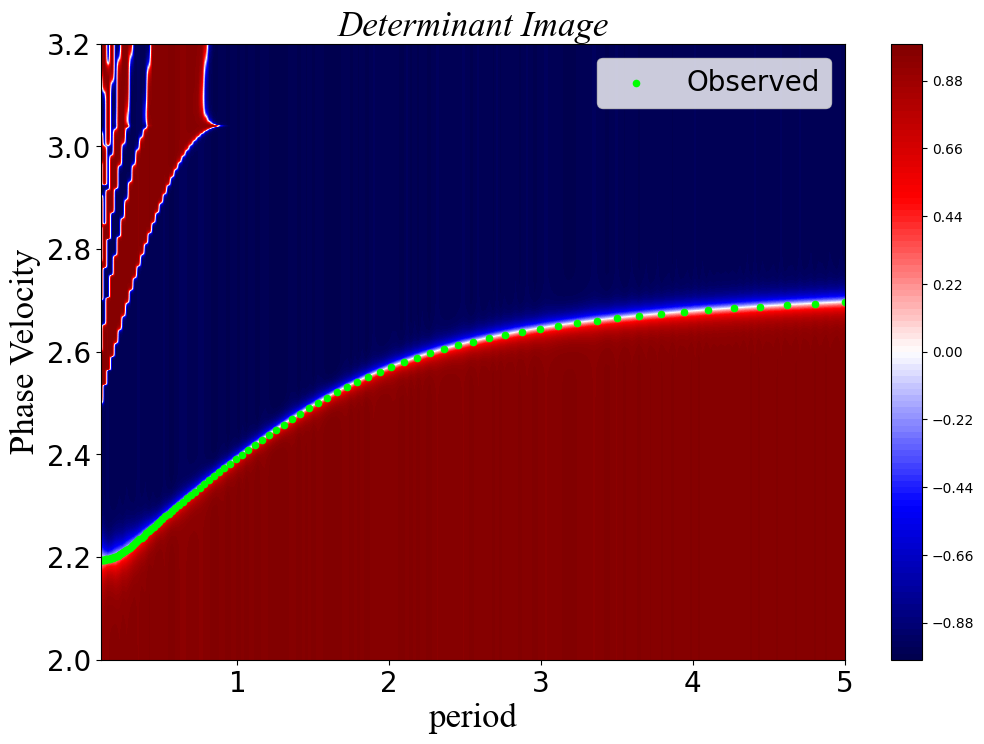

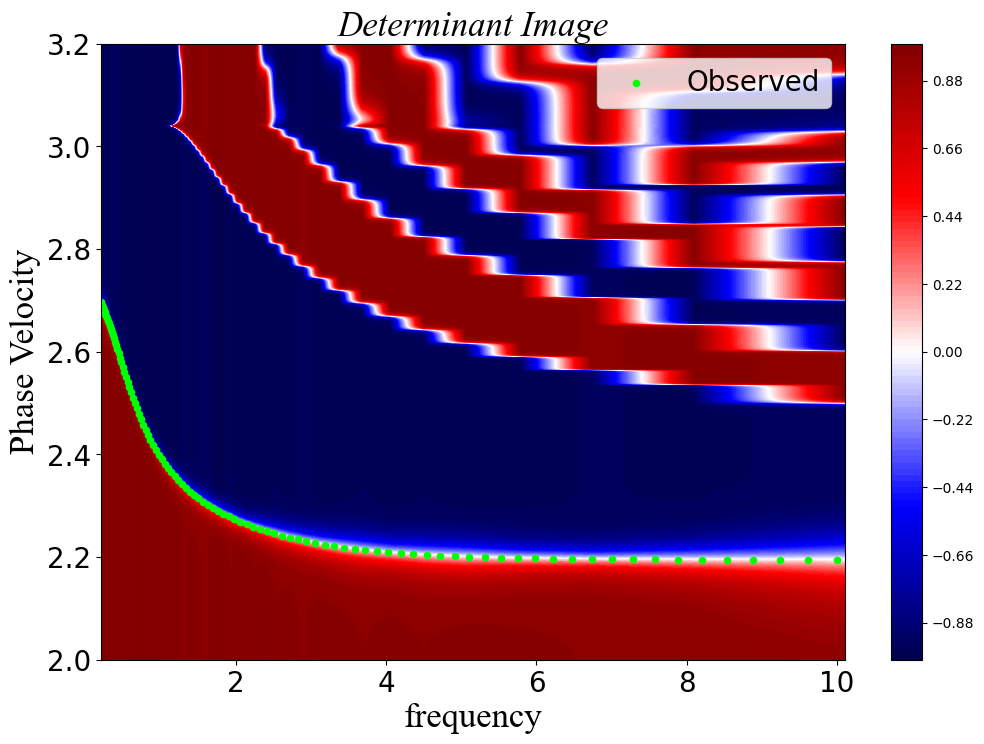

In [9]:
# numpy to tensor
d = numpy2tensor(inversion_model.inv_model["thick"])
rho=numpy2tensor(inversion_model.inv_model["rho"])
a = numpy2tensor(inversion_model.inv_model["vp"])
b = numpy2tensor(inversion_model.inv_model["vs"])
tlist = np.linspace(np.min(pvs_obs[:,0])-0.001,np.max(pvs_obs[:,0])+0.001,200)
clist = np.arange(vmin,vmax,0.001)
llw = 0 if b[0] <= 0.0 else -1
ifunc = ifunc_list[algorithm][wave]
# calculate the dispersion function's value
disp_matrix_init  = surf_matrix.dltar_matrix(clist, tlist, d,a, b,rho, ifunc, llw)
disp_matrix_symbol = torch.sign(disp_matrix_init.detach())
disp_matrix = disp_matrix_init/(torch.max(disp_matrix_init,dim=0).values - torch.min(disp_matrix_init,dim=0).values)
disp_matrix_compress = (1e-31)**torch.abs(disp_matrix)-1
disp_matrix_compress = disp_matrix_compress/(torch.max(disp_matrix_compress,dim=0).values - torch.min(disp_matrix_compress,dim=0).values)
disp_matrix_compress = disp_matrix_compress*disp_matrix_symbol
disp_matrix_plot = disp_matrix_compress
disp_matrix_plot[disp_matrix_plot>0] = disp_matrix_plot[disp_matrix_plot>0]/disp_matrix_plot.max()
disp_matrix_plot[disp_matrix_plot<0] = disp_matrix_plot[disp_matrix_plot<0]/np.abs(disp_matrix_plot.min())

plot_dispEnergyMap(tlist,clist,disp_matrix_plot,pvs_true=pvs_obs.copy(),
                # save_path=os.path.join(config.save_path,"005_InitModel_disp_energy_map_Period.png")
                )
plot_dispEnergyMap(tlist,clist,disp_matrix_plot,pvs_true=pvs_obs.copy(),
                # save_path=os.path.join(config.save_path,"005_InitModel_disp_energy_map_Frequency.png"),
                ptype="frequency")

In [10]:
import os 
import json 

def numpy2list(a):
    """
        transform numpy data into tensor
    """
    if not isinstance(a,list):
        return a.tolist()
    else:
        return a

config_res = {
    "model_param":{
        "vmin":model_parameter.vmin,
        "vmax":model_parameter.vmax,
        "dc":model_parameter.dc,
        "tmin":model_parameter.tmin,
        "tmax":model_parameter.tmax,
        "Nt":model_parameter.Nt,
        "layering_method":model_parameter.layering_method,
        "initialize_method":model_parameter.initialize_method,
        "layering_ratio":model_parameter.layering_ratio,
        "depth_factor":model_parameter.depth_factor,
        "layer_number":model_parameter.layer_number,
        "vp_vs_ratio":model_parameter.vp_vs_ratio,
        "rho":model_parameter.rho
    },
    "inv_param":{
        "inversion_method":inversion_parameter.inversion_method,
        "wave":inversion_parameter.wave,
        "algorithm":inversion_parameter.algorithm,
        "mode":inversion_parameter.mode,
        "compress":inversion_parameter.compress,
        "compress_method":inversion_parameter.compress_method,
        "lr":inversion_parameter.lr,
        "damp_vertical":inversion_parameter.damp_vertical,
        "damp_horizontal":inversion_parameter.damp_horizontal,
        "iteration":inversion_parameter.iteration,
        "step_size":inversion_parameter.step_size,
        "gamma":inversion_parameter.gamma,
        "optimizer":inversion_parameter.optimizer
    }
}

model_res = {
    "inv_model":{
        "vs":numpy2list(inversion_model.inv_model["vs"]),
        "vp":numpy2list(inversion_model.inv_model["vp"]),
        "rho":numpy2list(inversion_model.inv_model["rho"]),
        "thick":numpy2list(inversion_model.inv_model["thick"])
    },
    "init_model":{
        "vs":numpy2list(initial_model.init_model["vs"]),
        "vp":numpy2list(initial_model.init_model["vp"]),
        "rho":numpy2list(initial_model.init_model["rho"]),
        "thick":numpy2list(initial_model.init_model["thick"])
        },
    "inv_process":{
        "iter_vs":numpy2list(inversion_model.inv_process["iter_vs"]),
        "iter_thick":numpy2list(inversion_model.inv_process["iter_thick"]),
        "loss":numpy2list(inversion_model.inv_process["loss"])
    }
}
with open(os.path.join(data_path,"output/data/model.json"),"w") as f:
    json.dump(model_res,f)
    
with open(os.path.join(data_path,"output/data/config.json"),"w") as f:
    json.dump(config_res,f)
